### Import

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.layers import (
    Input, Embedding, Bidirectional,
    SimpleRNN, Dropout, Dense, Lambda
)
from tensorflow.keras.models import Model

### Load and preprocess data

In [2]:
df        = pd.read_csv('/content/Masked_morse_code_dataset.csv')
sentences = df['morse_masked_sentences'].astype(str).tolist()
labels    = df['labels'].astype(str).tolist()

### Align and Extract Mask Positions

In [3]:
# 3. Build vocab ↔ IDs
all_tokens = set()
for seq in sentences:
    all_tokens.update(seq.split())
all_tokens.update(labels)
vocab     = sorted(all_tokens)
token2id  = {tok: i for i, tok in enumerate(vocab)}
id2token  = {i: tok for tok, i in token2id.items()}

# 4. Encode & extract mask positions + label IDs
encoded, mask_pos, label_ids = [], [], []
for seq, lbl in zip(sentences, labels):
    toks = seq.split()
    ids  = [token2id[t] for t in toks]
    encoded.append(ids)
    mask_pos.append(toks.index('[MASK]'))
    label_ids.append(token2id[lbl])

# 5. Pad/truncate to fixed length
MAXLEN = 128
def pad_trunc(x):
    return x[:MAXLEN] if len(x) >= MAXLEN else x + [0] * (MAXLEN - len(x))

encoded   = np.array([pad_trunc(x) for x in encoded], dtype=np.int32)
mask_pos  = np.array([min(p, MAXLEN-1) for p in mask_pos], dtype=np.int32)
label_ids = np.array(label_ids, dtype=np.int32)

### Split the dataset in train and val datasets

In [4]:
train_ids, val_ids, train_pos, val_pos, train_lbl, val_lbl = train_test_split(
    encoded, mask_pos, label_ids,
    test_size=0.2
)

BATCH_SIZE = 64
def make_ds(ids, poses, lbls, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(
        ({"input_ids": ids, "mask_pos": poses}, lbls)
    )
    if shuffle:
        ds = ds.cache().shuffle(len(ids))
    else:
        ds = ds.cache()
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_ids, train_pos, train_lbl, shuffle=True)
val_ds   = make_ds(val_ids,   val_pos,   val_lbl,   shuffle=False)

### Model Definition

In [5]:
vocab_size = len(vocab)
embed_dim  = 128
rnn_units  = 64
drop_rate  = 0.5
l2_reg     = 1e-4

# 9. Build the network WITHOUT mask_zero so no RNN-mask is generated
inp_ids = Input(shape=(MAXLEN,), name="input_ids", dtype=tf.int32)
inp_pos = Input(shape=(),      name="mask_pos", dtype=tf.int32)

x = Embedding(
    input_dim=vocab_size,
    output_dim=embed_dim,
    mask_zero=False     # disable mask generation
)(inp_ids)

# Two fast CuDNN-backed SimpleRNN layers
x = Bidirectional(SimpleRNN(
    units=rnn_units,
    return_sequences=True,
    dropout=0.0,           # must be zero for CuDNN acceleration
    kernel_regularizer=l2(l2_reg)
))(x)
x = Dropout(drop_rate)(x)
x = Bidirectional(SimpleRNN(
    units=rnn_units,
    return_sequences=True,
    dropout=0.0,
    kernel_regularizer=l2(l2_reg)
))(x)
x = Dropout(drop_rate)(x)

# Extract the hidden-state at mask_pos
mask_repr = Lambda(
    lambda args: tf.gather(args[0], args[1], axis=1, batch_dims=1),
    output_shape=lambda shapes: (shapes[0][0], shapes[0][2])
)([x, inp_pos])

output = Dense(
    units=vocab_size,
    activation="softmax",
    kernel_regularizer=l2(l2_reg)
)(mask_repr)

model = Model([inp_ids, inp_pos], output)

# 10. Compile with AdamW + weight decay + gradient clipping
optimizer = AdamW(
    learning_rate=5e-4,
    weight_decay=1e-5,
    clipnorm=1.0
)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 128)  │      7,296 │ input_ids[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128, 128)  │     24,704 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128, 128)  │     24,704 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128)  │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_pos            │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ dropout_1[0][0],  │
│                     │                   │            │ mask_pos[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 57)        │      7,353 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 64,057 (250.22 KB)

 Trainable params: 64,057 (250.22 KB)

 Non-trainable params: 0 (0.00 B)

### Callbacks

In [6]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3,
                  restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                      patience=2, min_lr=1e-6, verbose=1)
]

### Train

In [7]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,  # early stop will kick in
    callbacks=callbacks
)

Epoch 1/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.0769 - loss: 3.6226 - val_accuracy: 0.1930 - val_loss: 2.9243 - learning_rate: 5.0000e-04
Epoch 2/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.1809 - loss: 2.9901 - val_accuracy: 0.2807 - val_loss: 2.5346 - learning_rate: 5.0000e-04
Epoch 3/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.2524 - loss: 2.6609 - val_accuracy: 0.3161 - val_loss: 2.3574 - learning_rate: 5.0000e-04
Epoch 4/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.2824 - loss: 2.4936 - val_accuracy: 0.3355 - val_loss: 2.2751 - learning_rate: 5.0000e-04
Epoch 5/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.3007 - loss: 2.4167 - val_accuracy: 0.3517 - val_loss: 2.2235 - learning_rate: 5.0000e-04
Epoch 6/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.3159 - loss: 2.3730 - val_accuracy: 0.3739 - val_loss: 2.1741 - learning_rate: 5.0000e-04
Epoch 7/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 11s 4

### Evaluate

In [8]:
loss, acc = model.evaluate(val_ds)
print(f"\nValidation loss = {loss:.3f}, accuracy = {acc:.3f}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4755 - loss: 1.8003

Validation loss = 1.776, accuracy = 0.481


### Graphs

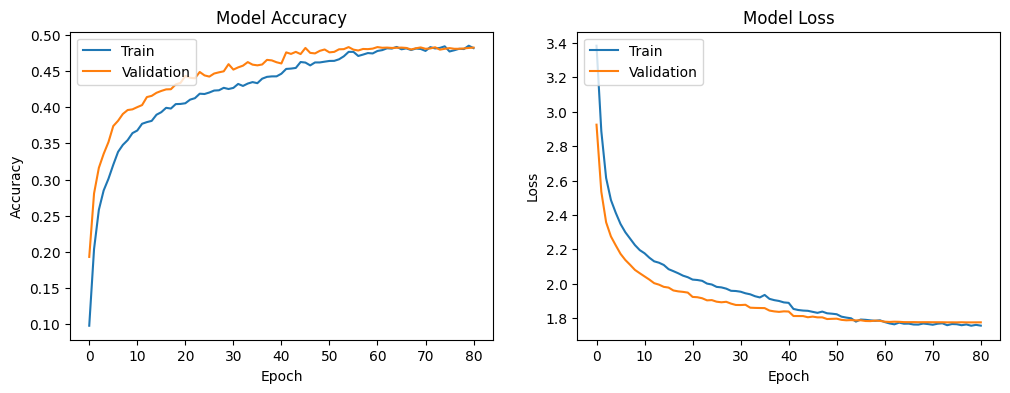

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Inference

In [10]:
def predict_mask(seq, top_k=5):
    toks   = seq.split()
    ids    = [token2id.get(t, 0) for t in toks]
    pos    = toks.index("[MASK]") if "[MASK]" in toks else 0
    padded = pad_trunc(ids)
    inp    = {
        "input_ids": np.array([padded], dtype=np.int32),
        "mask_pos":   np.array([pos],   dtype=np.int32)
    }
    logits = model.predict(inp)[0]
    probs  = tf.nn.softmax(logits).numpy()
    best   = np.argsort(probs)[-top_k:][::-1]
    return [(id2token[i], float(probs[i])) for i in best]

In [11]:
print(predict_mask(" -.-- --- ..- / -. . . -.. -.  - / -... . / [MASK] ..-. .-. .- .. -.. .-.-.-"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
[('.-', 0.02409418672323227), ('---', 0.01937221921980381), ('..-.', 0.0187422763556242), ('...', 0.018612997606396675), ('-', 0.018485600128769875)]
